<a id="top"></a>
# Exploring UV Extinction Curves
***
## Learning Goals

By the end of this tutorial, you will be able to:

- Perform data queries on the MAST archives using astroquery
- Narrow down query results to the desired spectrum
- Clean, analyze, and plot spectral data
- Fit extinction curves to a parameterized model

## Introduction

In this tutorial, you will learn how to download IUE data using the [MAST Archive API](https://astroquery.readthedocs.io/en/latest/mast/mast.html). We'll obtain the spectra of two stars, one reddened and one not. We will use these spectra to construct and plot UV extinction curves, then model this extinction.

**Extinction curve background**: An extinction curve demonstrates the wavelength dependence of dust extinction. It compares the dust-free Spectral Energy Distribution (SED) of a star to the observed SED affected by dust extinction. Normally these curves are created by plotting $k(\lambda-V)$ versus $1/\lambda$, with $\lambda$ being the wavelength (see 'Useful Equations' below).

Extinction is relevant in a diverse range of scenarios. Sometimes, dust is found very near the observed object, like in stars with disks or proto-stellar clouds. However, the target does not need to be intrinsically "dusty"; dust in a galaxy that is light-years from a target star might still block the line-of-sight view and impact the observation.


**International Ultraviolet Explorer (IUE)**: From 1978 until 1996, [the IUE](https://archive.stsci.edu/iue/) performed spectrophotometry in the wavelength range from 1150 Å to 3200 Å. The MAST Archive hosts these observations, which include more than 100,000 spectra.

**Magellanic Clouds**: Irregular dwarf galaxies that orbit the Milky Way galaxy and are located in the southern celestial hemisphere. Two distinct groups can be differentiated: the Large Magellanic Cloud (LMC) and the Small Magellanic Cloud (SMC).

**Defining some terms**:

- **Color index**: difference between magnitude of a star in two different passbands, typically B and V. Symbol: $(B-V)$. 
- **Extinction**: absoption and scattering of light by dust and gas between an object and the observer. It is a measure of the interstellar reddening quantified by the difference between the magnitude of the band when observed through dust versus a dust-free environment. Symbol: $A(\lambda)$.  

- **Spectral type**: stellar classification from hotter (O stars) to cooler (M stars). Temperature defines a star's "color" and surface brightness.


**Useful equations**
- $k(\lambda-V) = \frac{m(\lambda-V)-m(\lambda-V)_o}{(B-V)-(B-V)_o} = \frac{A(\lambda)-A(V)}{A(B)-A(V)}$ 

_**Note**: the $x_o$ terms refer to the star that is nearly unaffected by dust, i.e. $(B-V)$ corresponds to the observed color index and $(B-V)_o$ to the color index if there were no extinction due to dust. The stars should have the same spectral type in order to perform this comparison._

<!-- - The [Fitzpatrick and Massa (1990) parametrization](https://ui.adsabs.harvard.edu/abs/1990ApJS...72..163F/abstract): this will be the parametrization that will be followed in this tutorial for extinction curves. This parametrization is a combination of three elements; a linear "background term"; a Lorentsian-like "Drude" profile for the 2175 Å bump, $D(x; \gamma, x_o)$; finally, a far-UV curvature term, $F(x)$. The $x$ in the equation corresponds to $x = \lambda^{-1}$. 

$$\begin{equation}
 k(x-V) = c_1 + c_2x + c_3D(x; \gamma, x_o)+c_4F(x)
\end{equation}$$

$$\begin{equation}
 D(x; \gamma, x_o) = \frac{x^2}{(x^2-x_o^2)^2+x^2\gamma^2}
\end{equation}$$

$$\begin{equation}
 F(x) = \begin{cases}
    0.5392(x-5.9)^2+0.05644(x-5.9)^3, & \text{for $x \geq 5.9 \mu m^{-1}$}.\\
    0, & \text{otherwise}.
  \end{cases}
\end{equation}$$ -->
    
## Table of Contents
* [Imports](#Imports)
* [Searching by Target Name and Downloading Spectra](#Searching-the-MAST-archive-by-target-name-and-downloading-spectra)
* [Exploring the downloaded data files](#Exploring-the-downloaded-data-files)
* [Data access and manipulation](#Data-access-and-manipulation)
* [Saving values into your local computer](#Saving-values-into-your-local-computer)
* [Exercises](#Exercises)
* [Additional Resources](#Additional-Resources)

## Imports 

The first step will be to import the libraries we will be using throughout this tutorial: 

- `Observations` from [astroquery.mast](https://astroquery.readthedocs.io/en/latest/mast/mast.html) to query the MAST Archive.
- `fits` from _astropy.io_ for accessing FITS files
- `numpy` for array manipulations

In [1]:
from astroquery.mast import Observations
from astropy.io import fits
import numpy as np
from astroquery.simbad import Simbad
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt

_**Warning**: If you have not installed the astroquery package on your computer, you will need to. Information about astroquery can be found [on the readthedocs](https://astroquery.readthedocs.io/en/latest/)._

## Background and Targets

The first step is to find the data files we want to use. We will using the `Observations` Class from `astroquery.mast` both to search for and download UV data from the IUE.

We'll be targeting two stars: AzV 456 and AzV 380. This former is reddened by dust, while the latter is not. This particular example is from [Gordon et al. (2003)](https://ui.adsabs.harvard.edu/abs/2003ApJ...594..279G/abstract), but you can use any pair of reddened and unreddened stars with the same spectral type and luminosity class. Gordon et al. (2003) makes a good example because we want to explore the differences in extinction curves from stars belonging to the LMC and the SMC; more details on this are forthcoming in Part 2. 

## Searching and Downloading in astroquery.mast

The `query_criteria` function allows you to filter by mission, as well as object name. For a full list of fields you can query, as well as their associated metadata names, see the [CAOM fields description](https://mast.stsci.edu/api/v0/_c_a_o_mfields.html) page.

Again, our first target is AzV 456 and we want data from the IUE. Let's create a query to find matching results.

**Note: We'll use a radius of zero to exactly match our target; depending on your particular query, this may result in some missing observations. Use with caution!**

In [167]:
target_dusty = "Azv456"
target_nodust = "Azv70"

In [168]:
# We use a radius of zero to find exact matches
obs_table_dusty = Observations.query_criteria(obs_collection="IUE",
                                           objectname=target_dusty,
                                           radius = "0m",
                                           obs_title='A Far UV Study of Interstellar Matter in the Small Magellanic Cloud')
len(obs_table_dusty)

2

In [169]:
# Display the matching observations, if you want
obs_table_dusty.show_in_notebook()

idx,dataproduct_type,calib_level,obs_collection,obs_id,target_name,s_ra,s_dec,t_min,t_max,t_exptime,wavelength_region,filters,em_min,em_max,target_classification,obs_title,t_obs_release,instrument_name,proposal_pi,proposal_id,proposal_type,project,sequence_number,provenance_name,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,intentType,obsid,objID,objID1,distance
0,spectrum,2,IUE,lwr12347,SK143,17.731021553599987,-72.7178483056,44985.95799,44985.99965,3599.848,UV,LOW DISP,185142000000.0,334867000000.0,--,A Far UV Study of Interstellar Matter in the Small Magellanic Cloud,nan,LWR,Prevot,LP572,--,--,--,--,CIRCLE ICRS 17.7310215536 -72.7178483056 0.00300694444444,http://archive.stsci.edu/browse/previews/iue/mx/lwr/12000/gif/lwr12347.gif,http://archive.stsci.edu/pub/vospectra/iue2/lwr12347mxlo_vo.fits,PUBLIC,--,5885.0,science,302141,529019,529019,0.0
1,spectrum,2,IUE,swp16051,SK143,17.731021553599987,-72.7178483056,44986.00185,44986.07823,6599.755,UV,LOW DISP,115058000000.0,197869000000.0,--,A Far UV Study of Interstellar Matter in the Small Magellanic Cloud,nan,SWP,Prevot,LP572,--,--,--,--,CIRCLE ICRS 17.7310215536 -72.7178483056 0.00300694444444,http://archive.stsci.edu/browse/previews/iue/mx/swp/16000/gif/swp16051.gif,http://archive.stsci.edu/pub/vospectra/iue2/swp16051mxlo_vo.fits,PUBLIC,--,5885.0,science,314039,540917,540917,0.0


There are two matching observations. The first covers a short wavelength domain and the second covers the long domain (short and long are relative: both are UV observations). Let's use both so that we'll have a more complete picture of the extinction behavior over different wavelengths.

Let's find the data products associated with these observations. We'll use the `get_products` function to do that.

In [170]:
data_products_dusty = Observations.get_product_list(obs_table_dusty)

In [171]:
# Display the products, if you want
data_products_dusty.show_in_notebook()

idx,obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level
0,302141,IUE,spectrum,lwr12347,ELBLL,S,mast:IUE/url/pub/iue/data/lwr/12000/lwr12347.elbll.gz,AUXILIARY,--,--,--,--,--,LP572,lwr12347.elbll.gz,92557,302141,PUBLIC,2
1,302141,IUE,spectrum,lwr12347,LILO,S,mast:IUE/url/pub/iue/data/lwr/12000/lwr12347.lilo.gz,AUXILIARY,--,--,--,--,--,LP572,lwr12347.lilo.gz,472881,302141,PUBLIC,2
2,302141,IUE,spectrum,lwr12347,MELOL,S,mast:IUE/url/pub/iue/data/lwr/12000/lwr12347.melol.gz,AUXILIARY,--,--,--,--,--,LP572,lwr12347.melol.gz,11884,302141,PUBLIC,2
3,302141,IUE,spectrum,lwr12347,RAW,S,mast:IUE/url/pub/iue/data/lwr/12000/lwr12347.raw.gz,AUXILIARY,--,--,--,--,--,LP572,lwr12347.raw.gz,302980,302141,PUBLIC,2
4,302141,IUE,spectrum,lwr12347,RILO,S,mast:IUE/url/pub/iue/data/lwr/12000/lwr12347.rilo.gz,AUXILIARY,--,--,--,--,--,LP572,lwr12347.rilo.gz,308459,302141,PUBLIC,2
5,302141,IUE,spectrum,lwr12347,SILO,S,mast:IUE/url/pub/iue/data/lwr/12000/lwr12347.silo.gz,AUXILIARY,--,--,--,--,--,LP572,lwr12347.silo.gz,91136,302141,PUBLIC,2
6,302141,IUE,spectrum,lwr12347,Preview-Full,S,mast:IUE/url/browse/previews/iue/mx/lwr/12000/gif/lwr12347.gif,PREVIEW,--,--,--,--,--,LP572,lwr12347.gif,7767,302141,PUBLIC,2
7,302141,IUE,spectrum,lwr12347,MXLO,S,mast:IUE/url/pub/iue/data/lwr/12000/lwr12347.mxlo.gz,SCIENCE,Minimum Recommended Products,--,--,--,--,LP572,lwr12347.mxlo.gz,17796,302141,PUBLIC,2
8,302141,IUE,spectrum,lwr12347,(extracted spectra/vo spectral container/SSAP) fits file,S,mast:IUE/url/pub/vospectra/iue2/lwr12347mxlo_vo.fits,SCIENCE,Minimum Recommended Products,(extracted spectra/vo spectral container/SSAP) fits file,--,--,--,LP572,lwr12347mxlo_vo.fits,48960,302141,PUBLIC,2
9,314039,IUE,spectrum,swp16051,ELBLL,S,mast:IUE/url/pub/iue/data/swp/16000/swp16051.elbll.gz,AUXILIARY,--,--,--,--,--,LP572,swp16051.elbll.gz,85202,314039,PUBLIC,2


This looks good, but a fair number of these results are 'AUXILIARY'; they were orginially intended for calibration or engineering purposes. We want only the the products marked 'SCIENCE'; more specifically, we're looking for extracted spectra in `.fits` files. Let's add some filters to match those results.

In [172]:
filtered_products_dusty = Observations.filter_products(data_products_dusty,
                                                     productType='SCIENCE',
                                                     extension = '.fits')
len(filtered_products_dusty)

2

In [173]:
# Display the results, if you want
filtered_products_dusty.show_in_notebook(display_length=10)

idx,obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level
0,302141,IUE,spectrum,lwr12347,(extracted spectra/vo spectral container/SSAP) fits file,S,mast:IUE/url/pub/vospectra/iue2/lwr12347mxlo_vo.fits,SCIENCE,Minimum Recommended Products,(extracted spectra/vo spectral container/SSAP) fits file,--,--,--,LP572,lwr12347mxlo_vo.fits,48960,302141,PUBLIC,2
1,314039,IUE,spectrum,swp16051,(extracted spectra/vo spectral container/SSAP) fits file,S,mast:IUE/url/pub/vospectra/iue2/swp16051mxlo_vo.fits,SCIENCE,Minimum Recommended Products,(extracted spectra/vo spectral container/SSAP) fits file,--,--,--,LP572,swp16051mxlo_vo.fits,48960,314039,PUBLIC,2


Great! All that remains is to download the files. You can do this by passing the entire product table to the `download_products` function.

In [174]:
manifest_dusty = Observations.download_products(filtered_products_dusty)

INFO: Found cached file ./mastDownload/IUE/lwr12347/lwr12347mxlo_vo.fits with expected size 48960. [astroquery.query]
INFO: Found cached file ./mastDownload/IUE/swp16051/swp16051mxlo_vo.fits with expected size 48960. [astroquery.query]


Now, let's repeat this process for our second target: AzV 380. We'll condense the code into one cell for convenience.

In [175]:
obs_table_nodust = Observations.query_criteria(obs_collection="IUE",
                                            objectname=target_nodust,
                                            radius = "0m")

data_products_nodust = Observations.get_product_list(obs_table_nodust)

# Note that you can skip the 'filter products' step
# Instead, you can pass the filters directly to 'download_products'
manifest_nodust = Observations.download_products(data_products_nodust,
                                             productType='SCIENCE',
                                             extension = ".fits")

INFO: Found cached file ./mastDownload/IUE/lwp12387/lwp12387mxlo_vo.fits with expected size 51840. [astroquery.query]
INFO: Found cached file ./mastDownload/IUE/swp18830/swp18830mxlo_vo.fits with expected size 51840. [astroquery.query]


## Exploring the Downloaded Data Files

Now, let's explore the FITS file that we got for the reddened star. The filepaths were saved in our `manifest` variable when we used `download_products`.

In [176]:
# Pull the filepaths from the manifests
filenames_dusty = manifest_dusty['Local Path']
filenames_nodust = manifest_nodust['Local Path']

# The first path in the list is for the 'long wavelength' data
lw_dusty = filenames_dusty[0]

# We'll create the other files now, for convenience
sw_dusty = filenames_dusty[1]
lw_nodust = filenames_nodust[0]
sw_nodust = filenames_nodust[1]

# Print the information from the first file only
fits.info(lw_dusty)

Filename: ./mastDownload/IUE/lwr12347/lwr12347mxlo_vo.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     359   ()      
  1  Spectral Container    1 BinTableHDU    141   1R x 4C   [562E, 562E, 562E, 562I]   


- **No. 0 (PRIMARY)**: This HDU contains meta-data related to the entire file.
- **No. 1 (Spectral Container)**: This HDU contains the spectral profile of the target as a function of wavelength.

The header of the file contains additional information about the data. 

Let's take a look at some of the columns that are more relevant to us: 

In [177]:
with fits.open(lw_dusty) as hdulist: 
    header_lw_dusty = hdulist[1].header

# Remove to the [9:15] index to see the entire header
print(repr(header_lw_dusty[9:15]))

COMMENT  *** Column names ***                                                   
COMMENT                                                                         
TTYPE1  = 'WAVE    '           /                                                
TTYPE2  = 'FLUX    '           /                                                
TTYPE3  = 'SIGMA   '           /                                                
TTYPE4  = 'QUALITY '           /                                                


This tell us that first column corresponds to the wavelengths, and the second column to the fluxes. We can also see the units:

In [178]:
print(repr(header_lw_dusty[23:28]))

COMMENT   *** Column units ***                                                  
COMMENT                                                                         
TUNIT1  = 'angstrom'           / wavelength unit is Angstrom                    
TUNIT2  = 'erg/cm**2/s/angstrom' / flux unit is ergs/cm2/sec/A                  
TUNIT3  = 'erg/cm**2/s/angstrom' / sigma unit is ergs/cm2/sec/A                 


## Data Access and Validation

The data contained in this fits file can be accessed using `io.fits` and the `.data` attribute. This can be tedious to do more than once, so let's create a helper function to do it for us.

In [179]:
# This helper function will take a filename and return the wavelength/flux data
def extractData(filename):
    # Open the file and read the data
    with fits.open(filename) as hdulist:
        spectrum = hdulist[1].data
        
    # Extract our desired data from the corresponding columns
    wav = spectrum[0][0]   # wavelength, angstrom, A
    flux = spectrum [0][1] # flux, ergs/cm2/sec/A

    return wav, flux

Let's make sure we get a sensible result when we extract the data. We can make a plot to quickly see if anything is wrong with the results.

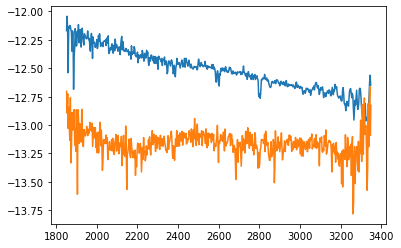

In [180]:
# Let's run our helper function on our data
wav_lw_dusty, flux_lw_dusty = extractData(lw_dusty)
wav_sw_dusty, flux_sw_dusty = extractData(sw_dusty)
wav_lw_nodust, flux_lw_nodust = extractData(lw_nodust)
wav_sw_nodust, flux_sw_nodust = extractData(sw_nodust)

# Let's also make a rough plot of our data, just so we can see what we're working with
plt.plot(wav_lw_nodust, np.log10(flux_lw_nodust))
plt.plot(wav_lw_dusty, np.log10(flux_lw_dusty))


## THOMAS: explain why we're looking for consistent lengths

In [181]:
# TBD: explain that we're checking for consistent data lengths

print(len(wav_lw_nodust), len(flux_lw_nodust), len(wav_lw_dusty), len(flux_lw_dusty))
print(len(wav_sw_nodust), len(flux_sw_nodust), len(wav_sw_dusty), len(flux_sw_dusty))
if len(wav_lw_nodust)!=len(wav_lw_dusty):
    wav_lw_nodust = wav_lw_nodust[:len(wav_lw_dusty)]
    flux_lw_nodust = flux_lw_nodust[:len(flux_lw_dusty)]
    
print(len(wav_lw_nodust), len(flux_lw_nodust), len(wav_lw_dusty), len(flux_lw_dusty))
print(len(wav_sw_nodust), len(flux_sw_nodust), len(wav_sw_dusty), len(flux_sw_dusty))

563 563 562 562
495 495 495 495
562 562 562 562
495 495 495 495


## Data Plotting

After searching for, downloading, and cleaning our data, we're finally ready to display the plot. We'll plot the flux against the inverse wavelength; this is customary for this type of study and follows the example in Gordon et al.

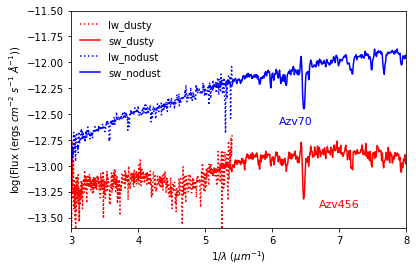

In [184]:
# Set up the plot size, labels, units
fig = plt.figure()
ax = plt.subplot(111)
ax.set_xlabel('1/$\lambda$ ($\mu m^{-1}$)')
ax.set_ylabel(r'log(Flux (ergs $cm^{-2}$ $s^{-1}$ $\AA^{-1}$))')
ax.set_xlim([3,8])
ax.set_ylim([-13.6, -11.5])

# Create a helper function to plot the data. We want to plot inverse wavelength against log of flux
def Plot(wav, flux, style, lbl):
    plt.plot(10**4/wav, np.log10(flux), style, label=lbl)

# Call the helper function four times: for long/short wavelengths of both 456 and 380
Plot(wav_lw_dusty, flux_lw_dusty, 'r:', 'lw_dusty')
Plot(wav_sw_dusty, flux_sw_dusty, 'r', 'sw_dusty')
Plot(wav_lw_nodust, flux_lw_nodust, 'b:', 'lw_nodust')
Plot(wav_sw_nodust, flux_sw_nodust, 'b', 'sw_nodust')

# Add some labels to our plot to clarify which spectrum is which
plt.text(6.7, -13.4, target_dusty, fontsize = 11, color='r')
plt.text(6.1, -12.6, target_nodust, fontsize = 11, color='b')

# Create the legend and show our plot
plt.legend(loc='best',frameon=False)
plt.show()

What a wonderful example of extinction! Both stars have the same spectral features, but we can see an enormous dimming of AzV456 in the shorter (bluer) wavelengths. Note that shorter wavelengths correspond to a larger value of $1/\lambda$; this region is plotted with solid lines in the figure.

## Extinction Curve

Let's now use the <a href="http://simbad.cds.unistra.fr/simbad/">SIMBAD</a> database to look for the fluxes in the B and V bands for both stars. We can do a simple query using the identifier of both stars. The magnitudes can be found under the 8th subgroup presented below the name of the stars, called 'Fluxes', since SIMBAD can provide you with either the flux or the magnitude of the star in those bands.


In [185]:
# Request the B and V magnitudes
Simbad.add_votable_fields('flux(B)','flux(V)')

# Query for AvZ 456
table_dusty = Simbad.query_object(target_dusty)


In [186]:
# Examine the data, if you want
table_dusty.show_in_notebook()

idx,MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE,FLUX_B,FLUX_V,FLUX_B_1,FLUX_V_1,FLUX_B_2,FLUX_V_2,FLUX_B_3,FLUX_V_3,FLUX_B_4,FLUX_V_4,FLUX_B_5,FLUX_V_5,FLUX_B_6,FLUX_V_6,SCRIPT_NUMBER_ID
,,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,
0,SK 143,01 10 55.7567,-72 42 56.223,14,14,0.439,0.425,90,A,O,2020yCat.1350....0G,12.98,12.89,12.98,12.89,12.98,12.89,12.98,12.89,12.98,12.89,12.98,12.89,12.98,12.89,1


Great. Let's get the data for AzV380 as well.

In [187]:
table_nodust = Simbad.query_object(target_nodust)

From these values we can directly calculate $E(B-V) = (B-V)-(B-V)_o$. We can do this since AvZ 380 is essentially an unreddened version of AvZ 456.

In [188]:
# Extract these values from the table
V_dusty = table_dusty['FLUX_V'][0]
B_dusty = table_dusty['FLUX_B'][0]

V_nodust = table_nodust['FLUX_V'][0]
B_nodust = table_nodust['FLUX_B'][0]

# Plug into the formula
EBV = (B_dusty-V_dusty)-(B_nodust-V_nodust)
print(f"The value of E(B-V) is equal to {EBV:.3f}")

The value of E(B-V) is equal to 1.530


Now we can fully plot the extinction curve!

$k(\lambda-V) = \frac{m(\lambda-V)-m(\lambda-V)_o}{(B-V)-(B-V)_o} = \frac{A(\lambda)-A(V)}{A(B)-A(V)}$

# EXPLAIN EQUATION HERE

## CLAIRE: advice from expert. do we eliminate the data points at the end of each wavelength band? is that due to detector effects?

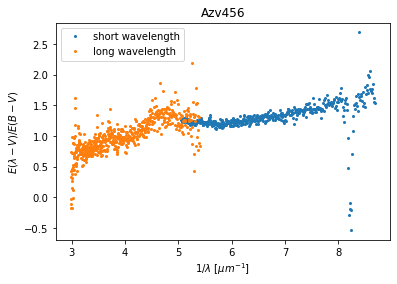

In [189]:
V_rat = V_dusty/V_nodust

# Another helper function to create our plots, and save the output data for further analysis
def Extinction(wav, flux1, flux2):
    flux_rat = flux1/flux2
    # Calcuating extinction from the formula 
    ext = np.log(V_rat/flux_rat)/EBV
    inv_wav= 10**4/wav
    plt.plot(inv_wav, ext, 'o', markersize=2)
    return inv_wav, ext 

# Create the figure, then use the helper function to create the plots and save the data
plt.figure()
s_inv_wav, s_ext = Extinction(wav_sw_dusty, flux_sw_dusty, flux_sw_nodust)
l_inv_wav, l_ext = Extinction(wav_lw_dusty, flux_lw_dusty, flux_lw_nodust)

# Add a title, axes labels, and a legend
plt.legend(['short wavelength', 'long wavelength'])
plt.xlabel(r'$1/\lambda$ $[\mu m^{-1}]$')
plt.ylabel(r'$E(\lambda-V)/E(B-V)$')
plt.title(target_dusty)
plt.show()

The values at the edge of the detectors don't look quite right. Particularly the right edge of the short wavelength; would we really expect the reddened star to be 20 orders of magnitude brighter in shorter wavelengths? Let's excise the data from the edges and try again.

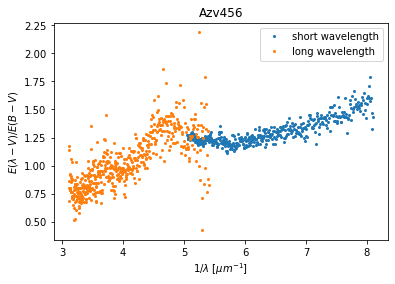

In [191]:
# How many points do we want to remove from either end of the data?
s_crop = 50
l_crop = -50

# Use helper function with cropped data
plt.figure()
s_inv_wav, s_ext = Extinction(wav_sw_dusty[s_crop:], flux_sw_dusty[s_crop:], flux_sw_nodust[s_crop:])
l_inv_wav, l_ext = Extinction(wav_lw_dusty[:l_crop], flux_lw_dusty[:l_crop], flux_lw_nodust[:l_crop])

# Add a title, axes labels, and a legend
plt.legend(['short wavelength', 'long wavelength'])
plt.xlabel(r'$1/\lambda$ $[\mu m^{-1}]$')
plt.ylabel(r'$E(\lambda-V)/E(B-V)$')
plt.title(target_dusty)
plt.show()

This is the typical shape encountered for extinction curves corresponding to the Small Magellanic Cloud (SMC), as can be seen in [Gordon et al. (2003)](https://ui.adsabs.harvard.edu/abs/2003ApJ...594..279G/abstract).

## Exercises

Now you can try to do it yourself! Try to obtain the spectra necessary to create an extinction curve of a star belonging to the Large Magellanic Cloud (LMC) following the steps presented for the SMC one.

### 1. Load the data

The targets for this exercise will be:

- Sk -69 206 (Observation IDs: swp36552, lwp15751) (reddened star)
- Sk -67 5 (Observation IDs: swp04827, lwr04170) (unreddened star)

First, do the database search for the reddened star:

In [ ]:
# You can copy, paste and modify the code corresponding to this part that we used for the SMC cloud here
# You can also use any function that was defined before


Narrow down the possibilities to the desired observation, observation ID: "swp36552":

In [ ]:
# You can copy, paste and modify the code corresponding to this part that we used for the SMC cloud here
# You can also use any function that was defined before


Now, download the data as before:

In [ ]:
# You can copy, paste and modify the code corresponding to this part that we used for the SMC cloud here
# You can also use any function that was defined before


And again, in order to cover a wider wavelength range, let's also download the other part of the spectra using the second observation ID provided, observation ID: "lwp15751":

In [ ]:
# You can copy, paste and modify the code corresponding to this part that we used for the SMC cloud here
# You can also use any function that was defined before


Now, let's do the same for the unreddened star:

In [ ]:
# You can copy, paste and modify the code corresponding to this part that we used for the SMC cloud here
# You can also use any function that was defined before


- Observation ID: "swp04827":

In [ ]:
# You can copy, paste and modify the code corresponding to this part that we used for the SMC cloud here
# You can also use any function that was defined before


In [ ]:
# You can copy, paste and modify the code corresponding to this part that we used for the SMC cloud here
# You can also use any function that was defined before


- Observation ID: "lwr04170"

In [ ]:
# You can copy, paste and modify the code corresponding to this part that we used for the SMC cloud here
# You can also use any function that was defined before


In [ ]:
# You can copy, paste and modify the code corresponding to this part that we used for the SMC cloud here
# You can also use any function that was defined before


### 2. Open the fits file and explore it

In [ ]:
# You can copy, paste and modify the code corresponding to this part that we used for the SMC cloud here
# You can also use any function that was defined before


### 3. Save the data to your local computer

In [ ]:
# You can copy, paste and modify the code corresponding to this part that we used for the SMC cloud here
# You can also use any function that was defined before


## Additional Resources

For more information about the MAST archive and details about mission data: 

* <a href="https://mast.stsci.edu/api/v0/index.html">MAST API</a> <br>
* <a href="https://archive.stsci.edu/iue/">International Ultraviolet Explorer Page (MAST)</a> <br>
* <a href="https://archive.stsci.edu/iue/mdr_help.html">IUE Data Retrieval Help Page</a> 

For more information about extinction curves and their parametrization:


* <a href="https://ui.adsabs.harvard.edu/abs/2003ApJ...594..279G/abstract">A quantitative comparison of SMC, LMC and Milky Way UV to NIR extinction curves</a> <br>
* <a href="https://adsabs.harvard.edu/pdf/1990ApJS...72..163F">An analysis of the shapes of the ultraviolet extinction curves. III. An atlas of ultraviolet extinction curves</a> 



As we can see from the obtained table, there are many different observations available for our target in the database. We specifically want to focus on sciences products, to know whether an observation is one we need to look at the _productType_ column, science products have the label 'SCIENCE'. Additionally, we will be using extracted spectra via the [Virtual Observatory (VO)](https://ivoa.net) using the [Simple Spectral Access Protocol (SSAP)](https://www.ivoa.net/documents/SSA/). The SSAP is the recommended way by VO to remotely access one dimensional spectra. In order to ensure this, the _description_ column should contain '(extracted spectra/vo spectral container/SSAP) fits file.'

Two different observations, "swp22372" for the short wavelength domain and "lwr17263" for the long wave domain, have been chosen in order to provide a more complete understanding of the extinction behaviour over different wavelengths. For this tutorial we have chosen these specific observations, but the reader is welcome to use any other of the IDs displayed on the table above, as long as they fulfill the conditions desribed in the previous paragraph.  It should be taken into account that some of the data may need some prior calibration before using it.

## About this Notebook

**Author**: Clara Puerto Sánchez <br>
**Keyword(s)**: UV, reddening, extinction-curve <br>
**Last Updated**: Sep 2022 <br>
**Next review**: Apr 2023

For support, please contact the Archive HelpDesk at archive@stsci.edu.
***
[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>